In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
from scipy.stats import pearsonr
from Main.HelperClasses.GetAraData import *

path_to_data='./data'
path_to_results='Main/results'
print(os.listdir())
araData = GetAraData(path_to_data='./data', maf=0.05, window_kb=200, r2=0.6)


['.git', 'figures', 'analysis.ipynb', 'figures1', 'Main', 'data', 'README.md', '.gitignore', 'environment.yml']


<h1> Filters the data as specified in section 2.1 <h1>

In [2]:
traits =  araData.get_trait_names()

# these traits are catagorical (this study only concerend with quantiative traits)
traits.remove('study_46_Gravitropic_setpoint_angle_GSA')
traits.remove('study_31_ScalingExponent')
traits.remove('study_37_Inter-specific_pollination_of_Arabidopsis_thaliana_and_Malcolmia_littorea')

def specfic_criteria(trait):
    """
    Used to further filter traits out of arapheno database
    """

    # study 2 contains multiple of the same trait measure on different occasaions
    # just want the blup main effect. 'size' traits are included in on arapheno
    # but not described
    if 'study_2_' in trait:
        return 'maineffect' in trait.lower() and 'size' not in trait.lower()

    # clim traits have no infomation as to what they are
    # rFitness is a product of two other traits already in the study
    if 'study_34_' in trait:
        return 'rFitness' not in trait and 'clim' not in trait
    
    return True

# gets all the phenotypes / accession using the trait names
all_pheno = {t:araData.get_normalised_phenotype(t) for t in traits}
all_accession = {t:araData.get_k2029_accessions_with_phenotype(t) for t in traits}
# hash table for the number of observations in each trait
len_hash = {t:len(all_pheno[t]) for t in traits}

# stores filtered traits
traits_filtered = []

# sort traits by the number of accession we have for them
traits = sorted(traits, key = lambda t:len_hash[t], reverse=True)

def compare_two_traits(trait1, trait2, cor=0.70):
    """
    checks corrleation of two traits using common accusession

    returns True is they are correlated < `cor`
    """
    
    trait1_phenos = all_pheno[trait1][
        np.in1d(all_accession[trait1], all_accession[trait2])]
    
    trait2_phenos = all_pheno[trait2][
        np.in1d(all_accession[trait2], all_accession[trait1])]

    if len(trait1_phenos) < 50:
        return True

    return max(r2_score(trait1_phenos, trait2_phenos), r2_score(trait2_phenos, trait1_phenos)) < cor

for trait_q in tqdm(traits):
    add_trait = True
    if not specfic_criteria(trait_q): continue
    for trait_added in traits_filtered:
        add_trait = compare_two_traits(trait_q,trait_added)
        add_trait = add_trait and len_hash[trait_q] > 100
        if not add_trait: break
    if add_trait:
        traits_filtered.append(trait_q)

print(f'{len(traits_filtered)} traits remain after the first stage of filtering')

100%|██████████| 555/555 [00:23<00:00, 23.54it/s] 

273 traits remain after the first stage of filtering


<h3> Secound stage of filtering, includes traits with an r2 > 0.2 in any linear model or random forest <h3>

In [3]:
result_path = f'{path_to_results}/all_traits_snps'
print(os.listdir())
print(result_path)
info = {'trait': [], 'model': [], 'r2': []}
used = []
# colect results
for trait in traits_filtered:
        try:
            df_lin = pd.read_csv(f'{result_path}/{trait}_linear.csv')[:3][['Model_Name', 'r2_summary']]   
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf.csv')[['Model_Name', 'r2_summary']]
        except:
            print(f'error reading {trait}')
            continue
        
        df = df_lin.merge(df_rf, how='outer')
        if max(df['r2_summary']) > 0.2:
            used.append(trait)
            info['trait'].append(trait)
            info['model'].append(list(df['Model_Name'])[np.argmax(df['r2_summary'])])
            info['r2'].append(list(df['r2_summary'])[np.argmax(df['r2_summary'])])
pd.DataFrame(info)

['.git', 'figures', 'analysis.ipynb', 'figures1', 'Main', 'data', 'README.md', '.gitignore', 'environment.yml']
Main/results/all_traits_snps


,trait,model,r2
0,study_12_FT10,Ridge,0.671666
1,study_38_CL,Ridge,0.467908
2,study_38_RL,Ridge,0.536353
3,herbavore_resistance_G4MSB,Random_Forest,0.477192
4,herbavore_resistance_G3HP,Lasso,0.508935
5,herbavore_resistance_G5MSP,Random_Forest,0.289233
6,herbavore_resistance_G2H3B,Ridge,0.505730
7,herbavore_resistance_G2H4P,Ridge,0.409070
8,herbavore_resistance_G2P,Random_Forest,0.440907
9,herbavore_resistance_G4P,Ridge,0.238915


<h3> Extract the trait ontologies for each trait from the arapheno database <h3>

In [4]:
path_to_all_studies = '/Research_Data_new/ReasearchProject/all_ara_pheno'
import re
from functools import reduce


def extract_study_number(input_str):
    # Regular expression to extract the study number
    match = re.search(r"study_(\d+)_", input_str)
    
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def extract_trait(input_str):
    # Regular expression to discard the study part and keep only the trait
    match = re.search(r"study_\d+_(.+)", input_str)
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def mine_trait_infomation(trait):
    info_retained = ['name', 'to_name','scoring','to_definition', 'study_number']
    study_number = extract_study_number(trait)
    trait_name = extract_trait(trait)
    try:
        path  = f'{path_to_all_studies}/{study_number}/study_{study_number}_phenotypes.csv'
        df = pd.read_csv(path)
        df['study_number'] = study_number
        df = df[df['name'] == trait_name][info_retained]
        if len(df) == 0: raise FileNotFoundError
        df = df[df['name'] == trait_name][info_retained]
        df['name'] = trait
        return df
    except FileNotFoundError:
        return pd.DataFrame({info:data for info, data in zip(info_retained, [[trait]] + [[np.NAN]]*(len(info_retained)-1))})

dfs = []
for trait in used:
    dfs.append(mine_trait_infomation(trait))

df_merged =  pd.concat(dfs)

print(list(df_merged['name']))
# copied
print(len(df_merged))
df_merged.sort_values('name', inplace=True)
df_merged


['study_12_FT10', 'study_38_CL', 'study_38_RL', 'herbavore_resistance_G4MSB', 'herbavore_resistance_G3HP', 'herbavore_resistance_G5MSP', 'herbavore_resistance_G2H3B', 'herbavore_resistance_G2H4P', 'herbavore_resistance_G2P', 'herbavore_resistance_G4P', 'herbavore_resistance_G3B', 'study_2_DTFmainEffect2009', 'study_2_YieldMainEffect2009', 'study_31_GrowthRate', 'study_31_FruitNumber', 'study_4_M130T666', 'study_16_Mo98', 'study_16_Cd111', 'study_126_Trichome_stem_length', 'study_44_root_length_day003', 'study_1_FT22', 'study_30_MeanTRL_CK', 'study_27_MeanTRL_C', 'study_1_FT_Field', 'study_1_LN10', 'study_1_LN16', 'study_1_Width_10', 'study_1_FLC', 'study_1_FRI', 'study_1_8W_GH_LN', 'study_1_8W_GH_FT', 'study_19_GR21', 'study_1_SDV', 'study_1_0W', 'study_1_Storage_56_days', 'study_1_Storage_28_days']
36


,name,to_name,scoring,to_definition,study_number
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN
0,study_126_Trichome_stem_length,NaN,NaN,NaN,NaN
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12


Manually fill missing values

In [5]:

manual_ont = {
    'study_38_CL':'plant morphology trait (TO:0000017)', 
    'study_126_Trichome_stem_length': 'plant morphology trait (TO:0000017)',
    'study_16_Cd111':'biochemical trait (TO:0000277)',
    'study_12_FT10': 'flowering time trait (TO:0002616)',
    'study_38_RL':'plant morphology trait (TO:0000017)',
    'herbavore_resistance_G4MSB':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3HP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G5MSP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H3B':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3B':'biochemical trait (TO:0000277)',
    'study_2_DTFmainEffect2009': 'flowering time trait (TO:0002616)',
    'study_2_YieldMainEffect2009':'yield trait (TO:0000387)',
    'study_31_GrowthRate': 'shoot system growth and development trait (TO:0000928)',
    'study_31_FruitNumber': 'yield trait (TO:0000387)',
    'study_4_M130T666':'biochemical trait (TO:0000277)',
    'study_16_Mo98':'biochemical trait (TO:0000277)',
    'study_44_root_length_day003': 'plant morphology trait (TO:0000017)',
    'study_1_FT22':'flowering time trait (TO:0002616)',
    'study_30_MeanTRL_CK': 'plant morphology trait (TO:0000017)',
    'study_27_MeanTRL_C': 'plant morphology trait (TO:0000017)',
    'study_1_FT_Field': 'flowering time trait (TO:0002616)',
    'study_1_LN10':'shoot system growth and development trait (TO:0000928)',
    'study_1_LN16':	'shoot system growth and development trait (TO:0000928)',
    'study_1_Width_10': 'plant morphology trait (TO:0000017)',
    'study_1_FLC': 'biochemical trait (TO:0000277)',
    'study_1_FRI': 'biochemical trait (TO:0000277)',
    'study_1_8W_GH_LN': 'shoot system growth and development trait (TO:0000928)',
    'study_1_8W_GH_FT':'flowering time trait (TO:0002616)',
	'study_19_GR21': 'seed dormancy trait (TO:0000253)',
    'study_1_SDV': 'flowering time trait (TO:0002616)',
    'study_1_0W': 'flowering time trait (TO:0002616)',
    'study_1_Storage_56_days':'seed dormancy trait (TO:0000253)',
    'study_1_Storage_28_days':'seed dormancy trait (TO:0000253)'  
}

manual_def = {
    'mineral and ion content trait (TO:0000465)': 'May be measured in a dry mass or in a fresh tissue. A biochemical trait (TO:0000277) that is the amount of a particular mineral or ion constituent occurring in a plant anatomical entity (PO:0025131).',
    'shoot system growth and development trait': 'A plant structure growth and development trait (TO:0000928) that is a quality of the growth of the shoot system (PO:0009006), and shoot system development stages (PO:0025527).'
}

best_model = pd.DataFrame(info).sort_values('trait')
df_merged['manual_ont'] = np.array(list(manual_ont.values()))[np.argsort(list(manual_ont.keys()))]
df_merged['best_model'] = ['Random Forest' if x == 'Random_Forest' else x for x in best_model['model']]

# remove one trait that has r1_tree
df_merged = df_merged[df_merged['best_model'] != 'r1_tree']
df_merged['ont_high']=['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]
df_merged.to_csv('Main/results/traits_used.csv', index=False)
df_merged

,name,to_name,scoring,to_definition,study_number,manual_ont,best_model,ont_high
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Lasso,biochemical trait
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,study_126_Trichome_stem_length,NaN,NaN,NaN,NaN,plant morphology trait (TO:0000017),Ridge,macroscopic trait
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12,flowering time trait (TO:0002616),Ridge,macroscopic trait


In [6]:
# gets the scores of every model on every trait
# as detailed in supplementary materials 

detailed_scores = {'trait': [], 'Ridge': [], 'Lasso': [], 'ElasticNet': [], 'RandomForest': [], 'MLP': []}

for trait in sorted(list(df_merged['name']), key = lambda x: (manual_ont[x], trait)):
    detailed_scores['trait'].append(trait)
    df_lin = pd.read_csv(f'{path_to_results}/all_traits_snps/{trait}_linear.csv')[:3][['Model_Name', 'r2_summary']]
    detailed_scores['Ridge'].append(list(df_lin['r2_summary'])[0])
    detailed_scores['Lasso'].append(list(df_lin['r2_summary'])[1])
    detailed_scores['ElasticNet'].append(list(df_lin['r2_summary'])[2])
    df_rf = pd.read_csv(f'{path_to_results}/all_traits_snps/{trait}_rf.csv')[['Model_Name', 'r2_summary']]
    detailed_scores['RandomForest'].append(list(df_rf['r2_summary'])[0])
    detailed_scores['MLP'].append(pd.read_csv(f'{path_to_results}/mlp_lasso_snps/{trait}.csv')['r2s'].mean())

detailed_scores = pd.DataFrame(detailed_scores)
# round each value to 4 decimal places
detailed_scores = detailed_scores.round(4) 
detailed_scores.to_csv('Main/results/detailed_scores.csv', index=False)
detailed_scores

,trait,Ridge,Lasso,ElasticNet,RandomForest,MLP
0,herbavore_resistance_G2H3B,0.5057,0.5011,0.4620,0.4775,0.4057
1,herbavore_resistance_G2H4P,0.4091,0.3727,0.3693,0.3744,0.1730
2,herbavore_resistance_G2P,0.3767,0.3768,0.3817,0.4409,0.2581
3,herbavore_resistance_G3B,0.3153,0.2446,0.2736,0.3105,0.0816
4,herbavore_resistance_G3HP,0.3638,0.5089,0.4429,0.4963,0.4151
5,herbavore_resistance_G4MSB,0.4601,0.4488,0.4391,0.4772,0.4247
6,herbavore_resistance_G4P,0.2389,0.2294,0.2354,0.1895,0.0383
7,herbavore_resistance_G5MSP,0.2575,0.2706,0.2609,0.2892,0.1820
8,study_16_Cd111,0.0489,0.2562,0.2379,0.2820,0.0208
9,study_16_Mo98,0.1323,0.1072,0.2389,0.3385,-0.0646


In [7]:
# number of accessions for each trait used in the study

detailed_scores = pd.read_csv('Main/results/detailed_scores.csv')
acc = []
for trait in detailed_scores['trait']:
    acc.append(len(araData.get_normalised_phenotype(trait)))
pd.DataFrame({'trait':detailed_scores['trait'], 'accessions':acc}).to_csv('Main/results/accessions.csv', index=False)
pd.DataFrame({'trait':detailed_scores['trait'], 'accessions':acc})

,trait,accessions
0,herbavore_resistance_G2H3B,595
1,herbavore_resistance_G2H4P,595
2,herbavore_resistance_G2P,595
3,herbavore_resistance_G3B,595
4,herbavore_resistance_G3HP,595
5,herbavore_resistance_G4MSB,595
6,herbavore_resistance_G4P,595
7,herbavore_resistance_G5MSP,595
8,study_16_Cd111,345
9,study_16_Mo98,345


These traits were then saved in the HelperFunctionsAndClasses/FileNameManger, such that they can be retieved with GetAraData.get_selected_traits()

<h3> Paper Figure 1a <h3>

Index(['biochemical trait (TO:0000277)', 'flowering time trait (TO:0002616)',
       'plant morphology trait (TO:0000017)',
       'seed dormancy trait (TO:0000253)',
       'shoot system growth and development trait (TO:0000928)',
       'yield trait (TO:0000387)'],
      dtype='object', name='manual_ont')


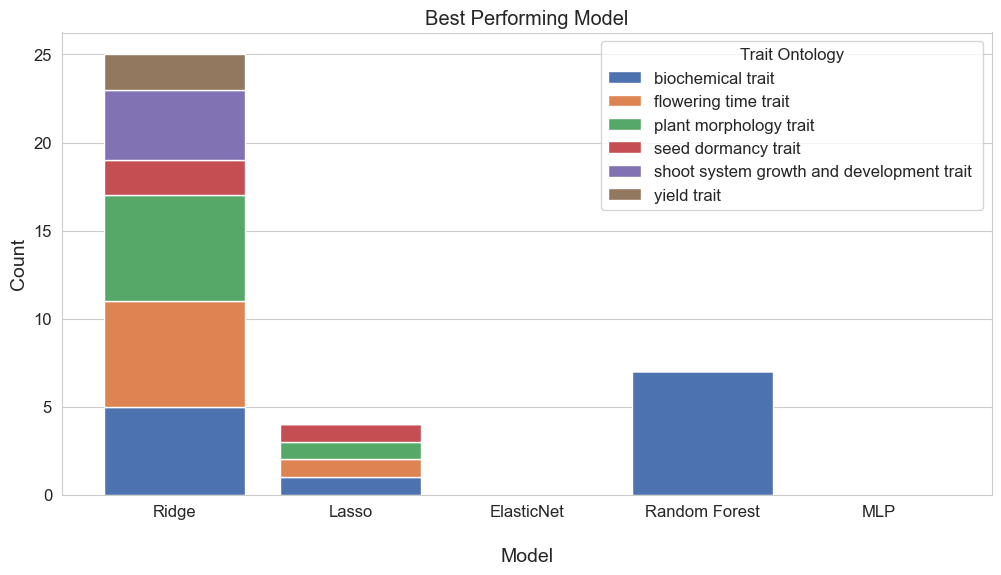

manual_ont,biochemical trait (TO:0000277),flowering time trait (TO:0002616),plant morphology trait (TO:0000017),seed dormancy trait (TO:0000253),shoot system growth and development trait (TO:0000928),yield trait (TO:0000387)
best_model,,,,,,
Ridge,5.0,6.0,6.0,2.0,4.0,2.0
Lasso,1.0,1.0,1.0,1.0,0.0,0.0
ElasticNet,0.0,0.0,0.0,0.0,0.0,0.0
Random Forest,7.0,0.0,0.0,0.0,0.0,0.0
MLP,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
# Desired order for categories
desired_order = ['Ridge', 'Lasso', 'ElasticNet', 'Random Forest',  'MLP']

# Count occurrences
df_count = df_merged.groupby(['best_model', 'manual_ont']).size().unstack(fill_value=0)

# Reorder df_count according to desired_order
df_count = df_count.reindex(desired_order)

# Apply Seaborn styles and set a palette
sns.set_style("whitegrid")
sns.set_palette("deep")
df_count.loc['MLP'] = 0
df_count.loc['ElasticNet'] = 0

print(df_count.columns)
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(df_count))

for type_col in df_count.columns:
    ax.bar(df_count.index, df_count[type_col], bottom=bottom, label=type_col[:type_col.index('(')])
    bottom += df_count[type_col].values

palette = sns.color_palette("deep") # You can change "deep" to any palette of your choice


ax.set_xlabel('Model', labelpad=20, fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Best Performing Model')
ax.legend(title='Trait Ontology')

ax.xaxis.grid(False)
ax.yaxis.grid(True)
path = '/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper'
plt.savefig(f'figures/figure_1a.svg')
plt.show()
df_count

<h3> Paper Figure 1b <h3>

Useful helper

In [9]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
def make_violin_plot(df, title=None, save_path=None, format='svg', palette=None, ax=None, tilt=0, size=4, min_max=None, fig_size= None, x_label = None, draw_connections=True):
    plt.clf()
    sns.reset_defaults()
    if fig_size:
        sns.set(rc={'figure.figsize': fig_size})
    if palette:
        sns.set_palette(palette)
    else:
        sns.set_palette(None)

    sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 12})
    sns.swarmplot(data=df, size=size, ax=ax, palette=palette)
    # remove points that are outside 1.5 * IQR
    #sns.boxplot(data=df,color="#E6E6E6", ax=ax)
    means = df.mean(axis=0)
    plt.scatter(x=range(len(means)),y=means,c="k", zorder=10, marker='_', s=2000)

    sns.violinplot(data=df, inner=None, color="#E6E6E6", ax=ax)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=tilt)
    plt.ylabel(r"$\text{r}^2$", fontsize=14)
    plt.xlabel(x_label)
    if min_max:
        plt.ylim(*min_max)


    if draw_connections:
        for idx0, idx1 in zip([i * 2 for i in range(len(df.columns)//2)],[i * 2 + 1 for i in range(len(df.columns)//2)]):
            print(idx0, idx1)
            print(plt.gca().get_children())
            locs1 = plt.gca().get_children()[idx0].get_offsets()
            locs2 = plt.gca().get_children()[idx1].get_offsets()

            # before plotting, we need to sort so that the data points
            # correspond to each other as they did in "set1" and "set2"
            sort_idxs1 = np.argsort(list(df[df.columns[idx0]]))
            sort_idxs2 = np.argsort(list(df[df.columns[idx1]]))

            # revert "ascending sort" through sort_idxs2.argsort(),
            # and then sort into order corresponding with set1
            locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]

            for i in range(locs1.shape[0]):
                x = [locs1[i, 0], locs2_sorted[i, 0]]
                y = [locs1[i, 1], locs2_sorted[i, 1]]
                if y[0] > y[1]:
                    plt.plot(x, y, color="red", alpha=0.1)
                else:
                    plt.plot(x, y, color="blue", alpha=0.1)

    if title:
        plt.title(title, fontsize=16)
    if save_path:
        pass
        #plt.savefig(save_path, format=format, dpi=300)
    if ax is None:
        return plt

[10, 10, 10, 10, 10, 10, 10, 10]


/tmp/ipykernel_3564172/1010655131.py:18: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(data=df, size=size, ax=ax, palette=palette)


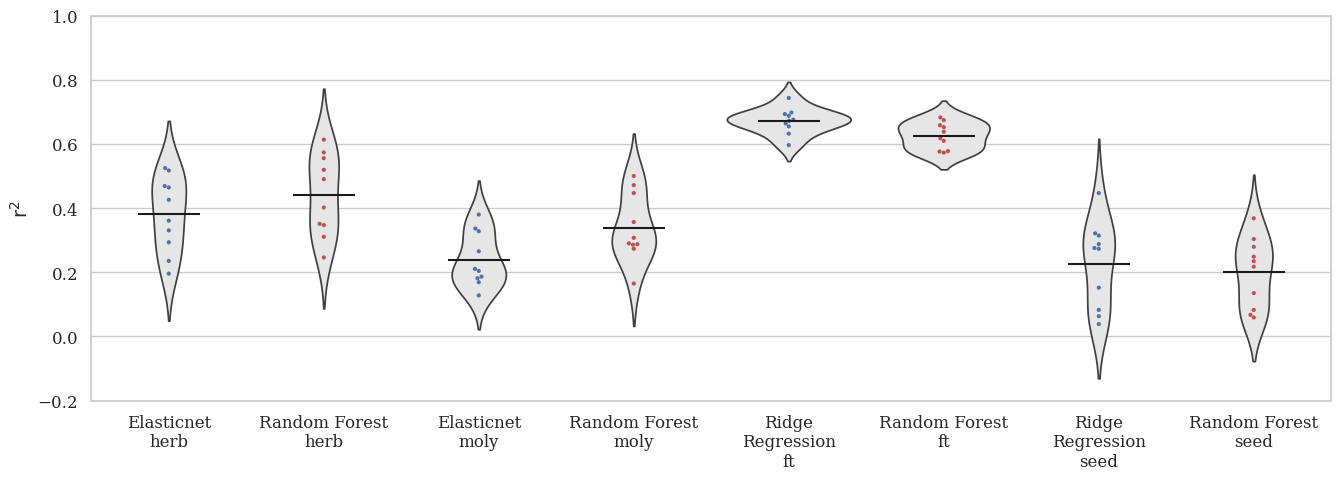

TtestResult(statistic=-5.720056347344639, pvalue=0.00028693476236372394, df=9)
TtestResult(statistic=-7.614458983830722, pvalue=3.2771112820157474e-05, df=9)
TtestResult(statistic=5.42698872332213, pvalue=0.000418009781328021, df=9)
TtestResult(statistic=2.050760873747798, pvalue=0.07052688020917222, df=9)


In [11]:
best_lin_herb = pd.read_csv(f'{path_to_results}/all_traits_snps/herbavore_resistance_G2P_linear_verbose.csv')
best_lin_herb = np.best_lin_herb = np.array(best_lin_herb[(best_lin_herb['Model_Name'] == 'ElasticNet') & (best_lin_herb['feature_represenation'] == 'SNPs')]['r2s'])
rf_herb = pd.read_csv(f'{path_to_results}/all_traits_snps/herbavore_resistance_G2P_rf_verbose.csv')
rf_herb = np.array(np.array(rf_herb[rf_herb['Model_Name'] == 'Random_Forest']['r2s']))

best_lin_moly = pd.read_csv(f'{path_to_results}/all_traits_snps/study_16_Mo98_linear_verbose.csv')
best_lin_moly = np.array(best_lin_moly[best_lin_moly['Model_Name'] == 'ElasticNet']['r2s'])
rf_moly = pd.read_csv(f'{path_to_results}/all_traits_snps/study_16_Mo98_rf_verbose.csv')
rf_moly = rf_moly[rf_moly['Model_Name'] == 'Random_Forest']['r2s']

best_lin_ft = pd.read_csv(f'{path_to_results}/all_traits_snps/study_12_FT10_linear_verbose.csv')
best_lin_ft = np.array(best_lin_ft[(best_lin_ft['Model_Name'] == 'Ridge') & (best_lin_ft['feature_represenation'] == 'SNPs')]['r2s'])
rf_ft = pd.read_csv(f'{path_to_results}/all_traits_snps/study_12_FT10_rf_verbose.csv')
rf_ft = rf_ft[rf_ft['Model_Name'] == 'Random_Forest']['r2s']

best_lin_seed_weight = pd.read_csv(f'{path_to_results}/all_traits_snps/study_2_YieldMainEffect2009_linear_verbose.csv')
best_lin_seed_weight = np.array(best_lin_seed_weight[(best_lin_seed_weight['Model_Name'] == 'Ridge') & (best_lin_seed_weight['feature_represenation'] == 'SNPs')]['r2s'])
rf_seed_weight = pd.read_csv(f'{path_to_results}/all_traits_snps/study_2_YieldMainEffect2009_rf_verbose.csv')
rf_seed_weight = rf_seed_weight[rf_seed_weight['Model_Name'] == 'Random_Forest']['r2s']

e= ({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})
print([len(x) for x in e.values()])
df = pd.DataFrame({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})

make_violin_plot(df = df[:10], size=3, fig_size=(16,5), palette=[sns.color_palette()[int(i%2==0)*3] for i in range(6)], draw_connections=False)#.savefig('genomic_prediction_programs/Experiments/TorchPractice/lassorfsummery.svg')
plt.ylim(-0.2,1)
plt.savefig('figures/figure_1b.svg')

plt.show()

# paired t test
import scipy
print(scipy.stats.ttest_rel(np.array(best_lin_herb), np.array(rf_herb)))
print(scipy.stats.ttest_rel(np.array(best_lin_moly), np.array (rf_moly)))
print(scipy.stats.ttest_rel(np.array(best_lin_ft), np.array (rf_ft)))
print(scipy.stats.ttest_rel(np.array(best_lin_seed_weight), np.array (rf_seed_weight)))

In [15]:
pc_best = pd.read_csv(f'{path_to_results}/best_model_pca_0.3_var/best_pc_model_0.3.csv').sort_values('trait')
macro, biochem = [], []

info = pd.DataFrame(info).sort_values('trait')

for markers, pc, ont, trait in zip(pd.DataFrame(info).sort_values('trait')['r2'], pc_best.sort_values('trait')['r2_best'], df_merged['manual_ont'],
                                   df_merged['name']):
    for markers, pc, ont, trait in zip(pd.DataFrame(info).sort_values('trait')['r2'], pc_best.sort_values('trait')['r2_best'], df_merged['manual_ont'],
                                       df_merged['name']):
        print(f"{trait:<35} {markers:.3f} {pc:.3f}")
    ratio = pc/markers
    if ont == 'biochemical trait (TO:0000277)':
        biochem.append(ratio)
    else:
        macro.append(ratio)


data1 = pd.DataFrame({'ratio': [a/b for a,b in zip(pc_best['r2_best'], info['r2'])], 
                     'ont': ['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]})


print(data1.groupby('ont').mean())


herbavore_resistance_G2H3B          0.506 0.537
herbavore_resistance_G2H4P          0.409 0.436
herbavore_resistance_G2P            0.441 0.391
herbavore_resistance_G3B            0.315 0.297
herbavore_resistance_G3HP           0.509 0.304
herbavore_resistance_G4MSB          0.477 0.400
herbavore_resistance_G4P            0.239 0.231
herbavore_resistance_G5MSP          0.289 0.249
study_126_Trichome_stem_length      0.269 0.257
study_12_FT10                       0.672 0.653
study_16_Cd111                      0.282 0.038
study_16_Mo98                       0.338 0.138
study_19_GR21                       0.559 0.488
study_1_0W                          0.530 0.512
study_1_8W_GH_FT                    0.486 0.443
study_1_8W_GH_LN                    0.470 0.389
study_1_FLC                         0.339 0.188
study_1_FRI                         0.220 0.090
study_1_FT22                        0.393 0.391
study_1_FT_Field                    0.527 0.562
study_1_LN10                        0.48

In [16]:
lat_long_10001 = pd.read_csv('/Research_Data_new/ReasearchProject/data/10001_genomes_lat_long.csv')

result = {'trait': [], 'r2': []}
for trait in df_merged['name']:
    phenotypes = araData.get_normalised_phenotype(trait)
    accessions = araData.get_k2029_accessions_with_phenotype(trait).astype(int)
    lat_long = lat_long_10001[np.isin(np.array(lat_long_10001['Accession ID']), accessions)][['Lat', 'Long']]
   
    lat = np.array(lat_long['Lat'])
    long = np.array(lat_long['Long'])

    lat_min, lat_max = -40, 60
    long_min, long_max = 20,70
    nans = np.argwhere(np.isnan(lat))
    lat = (np.delete(lat,nans,0))
    long = (np.delete(long,nans,0))

    x,y = np.vstack((long**2, lat**2)).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]))).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]), long**2, lat**2)).T, phenotypes


    y = np.delete(y,nans,0)

    in_lat = (x[:,0] > lat_min) & (x[:,0] < lat_max)
    in_long = (x[:,1] > long_min) & (x[:,1] < long_max)
    in_domain = in_lat & in_long
    x,y = x[in_domain], y[in_domain]
    if len(x) < 10:
        print(trait)
        continue
    
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    result['trait'].append(trait)
    result['r2'].append(r2_score(y,y_pred))
    

data2 = pd.DataFrame({'trait': result['trait'], 'ontology': df_merged['ont_high'], 'r2': result['r2']})

print(data2[data2['ontology'] == 'macroscopic trait']['r2'].mean())
print(data2[data2['ontology'] == 'biochemical trait']['r2'].mean())

0.24517180752422008
0.14020574040245184


In [17]:

import os
import pandas as pd
import scipy

path_to_gwas = '/Research_Data_new/ReasearchProject/gwas'
print(os.listdir())

def mine_GWAS(trait):
    return pd.read_csv(f'{path_to_gwas}/{trait}/Output/Linear_Mixed_Model/{trait}/{trait}_mod_sub_{trait}_k2029.assoc.txt', sep='\t')

def get_skewness(trait, skew=False):
    return scipy.stats.kurtosis(np.log((mine_GWAS(trait)['p_wald'])))


import seaborn as sns
data3 = pd.DataFrame({'trait ontology': df_merged['ont_high'], 'skew': map(lambda x:get_skewness(x,skew=False), list(df_merged['name'])), 'best_model': list(df_merged['best_model']), 'name': list(df_merged['name'])})
#data3['best_model'].replace('Random_Forest_vanilla', 'Random Forest', inplace=True)
skew_dict = {k:v for k, v in zip(list(df_merged['name']), list(data3['skew']))}
data3['skew'] = np.log(data3['skew'])


['.git', 'figures', 'analysis.ipynb', 'figures1', 'Main', 'data', 'README.md', '.gitignore', 'environment.yml']


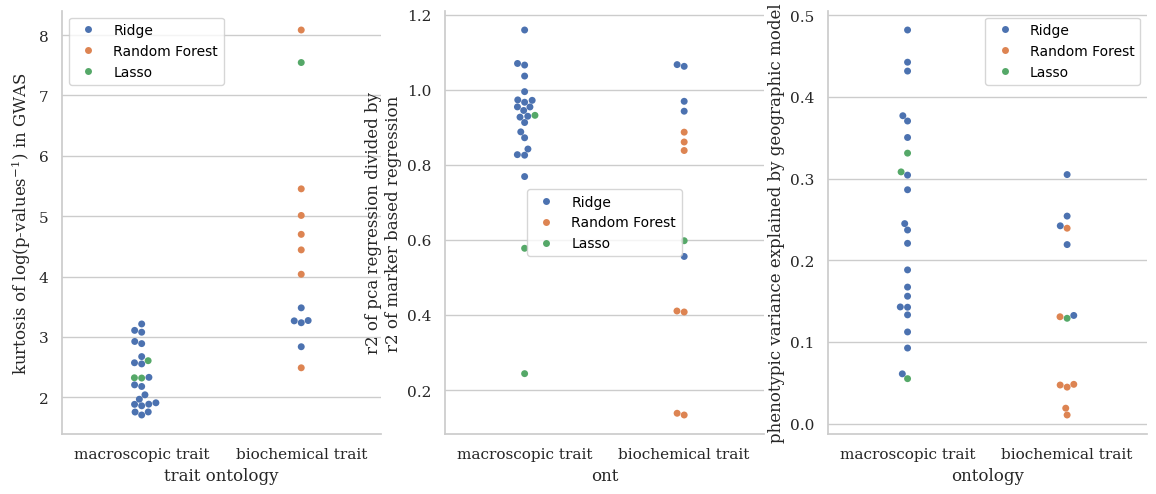

TtestResult(statistic=5.5465381947288765, pvalue=3.34679287424718e-06, df=34.0)
TtestResult(statistic=2.519415334726962, pvalue=0.016620810129008134, df=34.0)
TtestResult(statistic=2.552755481468493, pvalue=0.015347188942866175, df=34.0)


In [18]:
fig, axs = plt.subplots(1,3,figsize=(14,5.5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# increase font si
sns.reset_orig()


sns.swarmplot(data = data3, x= 'trait ontology', y = 'skew', hue =list(df_merged['best_model']), ax=axs[0], order=['macroscopic trait', 'biochemical trait'],  palette='deep')
axs[0].set_ylabel('kurtosis of log(p-values$\mathregular{^{-1}}$) in GWAS')

sns.swarmplot(data1, x='ont', y='ratio', hue=list(df_merged['best_model']), ax=axs[1], palette='deep', order=['macroscopic trait', 'biochemical trait'])
axs[1].set_ylabel('r2 of pca regression divided by\nr2 of marker based regression')

sns.swarmplot(data2, x = 'ontology', y = 'r2', hue=list(df_merged['best_model']), palette='deep', ax=axs[2], order=['macroscopic trait', 'biochemical trait'])                                     
axs[2].set_ylabel('phenotypic variance explained by geographic model')

for i in range(3):
    ax.tick_params(axis='y', labelsize=7)
    for pos in ['right', 'top' ]: 
        axs[i].spines[pos].set_visible(False) 

plt.savefig(f'figures/figure_2.svg')
plt.show()
print(scipy.stats.ttest_ind(data3[data3['trait ontology'] == 'biochemical trait']['skew'], data3[data3['trait ontology'] == 'macroscopic trait']['skew']))
print(scipy.stats.ttest_ind(data1[data1['ont'] == 'macroscopic trait']['ratio'], data1[data1['ont'] == 'biochemical trait']['ratio']))
print(scipy.stats.ttest_ind(data2[data2['ontology'] == 'macroscopic trait']['r2'], data2[data2['ontology'] == 'biochemical trait']['r2']))



<h3>Figure 3<h3>

In [19]:
feature_rep = 'PCA_SNPs'
metric = 'r2s'
import pandas as pd

def get_pca_mlp(trait, model):
    df =  pd.read_csv(f'{path_to_results}/mlp_pca/{trait}.csv')
    return (df[metric].groupby(df['variance_maintained']).mean())

def get_pca_rf(trait, model):
    df = pd.read_csv(f'{path_to_results}/rf_pca/{trait}_rf_verbose.csv')
    return (df[metric].groupby(df['variance_maintained']).mean())


def get_pca_regression(trait, model):
    df = pd.read_csv(f'{path_to_results}/linear_pca/{trait}_linear_verbose.csv')
    df = df[df['Model_Name'] == model]
    return df[metric].groupby(df['variance_maintained']).mean()

def get_baseline(trait, model):
    if model == 'rf':
        r = np.array(pd.read_csv(f'{path_to_results}/all_traits_snps/{trait}_rf_verbose.csv')[metric]).mean()
    if model == 'MLP':
        r = np.array(pd.read_csv(f'{path_to_results}/mlp_lasso_snps/{trait}.csv')[metric]).mean()
    if model in ['Ridge', 'Lasso', 'ElasticNet']:
        df = pd.read_csv(f'{path_to_results}/all_traits_snps/{trait}_linear.csv')
        r =  np.array(df[df['Model_Name'] == model]['r2_summary'])[0]
    return r    


trait = 'study_4_M130T666'

feature_representation = 'PCA_SNPs'
models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]

model_f = {'Ridge':get_pca_regression, 'Lasso':get_pca_regression, 'ElasticNet':get_pca_regression, 'MLP':get_pca_mlp, 'rf':get_pca_rf}

def get_datas(trait):
    datas = {}
    for model in models:
        datas[model] = model_f[model](trait, model)
    return pd.DataFrame(datas)
        

print(get_datas(trait))

                           rf       MLP  ElasticNet     Lasso     Ridge
variance_maintained                                                    
0.05                -0.072614  0.027547   -0.011071  0.003307  0.003580
0.10                 0.005539  0.140630    0.057873  0.093361  0.096437
0.20                 0.050507  0.093074    0.053221  0.077693  0.097407
0.30                 0.060074 -0.001928    0.058273  0.074785  0.079181
0.40                 0.058720  0.132623    0.067342  0.077867  0.096636
0.50                 0.052737 -0.020823    0.039675  0.062958  0.097062
0.60                 0.051997  0.129492    0.025985  0.085283  0.125246
0.70                 0.035035  0.135077    0.024085  0.078065  0.095499
0.80                 0.029934  0.166466    0.015757  0.084331  0.120147
0.90                 0.024495  0.107083    0.015918  0.079438  0.113303
0.95                 0.025985  0.104834    0.020189  0.080979  0.128180
0.97                 0.020518  0.135877    0.015385  0.081036  0

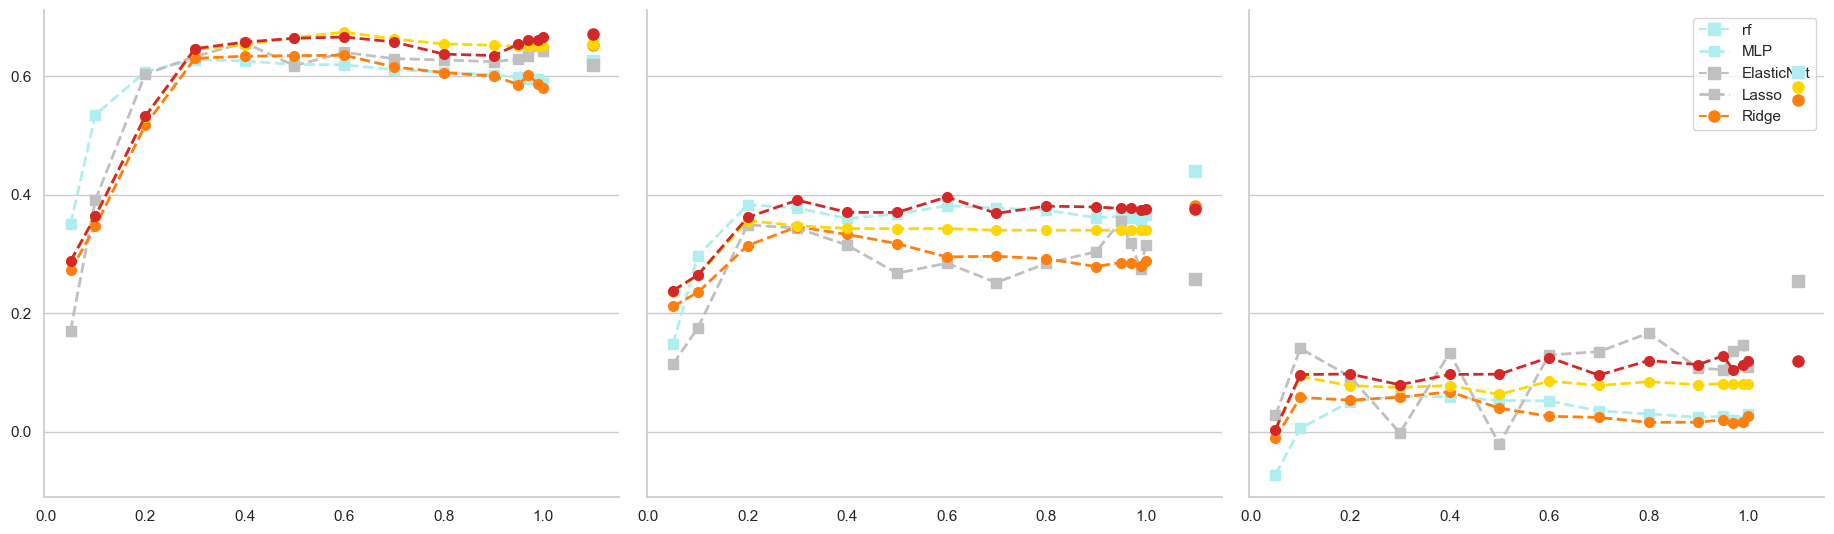

In [21]:
colors = ['tab:red', 'gold', 'tab:orange', 'silver', 'paleturquoise'][::-1]
import seaborn as sns
sns.set_theme(style='whitegrid')
connections = []

fig, axs = plt.subplots(1,3, sharey = True, figsize=(18.5, 5.5))

for ax in axs:
    ax.grid(axis='x')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

    for pos in ['right', 'top' ]: 
        ax.spines[pos].set_visible(False) 


models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]
traits = ['study_12_FT10','herbavore_resistance_G2P', 'study_4_M130T666']
for axis, trait in zip(axs, traits):
    data = get_datas(trait)
    for i, model in enumerate(models):
        if i  < 2: marker = 's'
        else: marker = 'o'
        color = colors[i]

        base = get_baseline(trait, model)

        axis.plot(1.1, [base], color=color,linestyle='--', marker=marker,  zorder=100, markersize=8)
        axis.plot(data.index, (data[model]), color=color, linestyle='--', marker=marker, zorder=100, markersize=7, linewidth=2)


# add figure legand
plt.legend(models, loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(f"figures/figure_3b.svg")
plt.show()

In [22]:
path_to_gwas = '/Research_Data_new/ReasearchProject/gwas'
def plot_gwas(trait, ax, y_ticks=True, x_ticks=True, skew_info=True, title=True, fontsize=6):
    colors = ['#4C72B0', '#C44E52']
    path_to_file = f'{trait}/Output/Linear_Mixed_Model/{trait}/{trait}_mod_sub_{trait}_k2029.assoc.txt'
    df = pd.read_csv(f'{path_to_gwas}/{path_to_file}', sep='\t')
    x = np.arange(len(df))
    y =  -np.log10(df['p_wald'])
    # remove where x == 0

    include = np.where(y > 0.01)[0]
    x = x[include]
    y = y[include]
    chrs = np.array(df['chr'])
    point_colors = [colors[0] if chr%2 else colors[1] for chr in chrs[include]]
    ax.scatter(x,y, color=point_colors, s=0.5)
    ax.axhline(-np.log10(5*(10**(-8))), color='black', linestyle='-', linewidth = 1)
    ax.set_ylim(0,20)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    # remove x ticks
    labels = [1,2,3,4,5]
    ax.set_xticks(labels=labels, ticks=[(np.where(chrs==x)[0][0] + np.where(chrs==x)[0][-1])/2 for x in labels], rotation=45, fontweight="bold"
                  )

    #  set front size 
    for label in ax.get_xticklabels():
        label.set_fontsize(fontsize)
    for label in ax.get_yticklabels():
        label.set_fontsize(fontsize)

    if skew_info:
        ax.text(0.02, 0.95, f"log(Kurtosis(-log pval): {round(skew_dict[trait], 3)}", transform=ax.transAxes, fontsize=7, verticalalignment='top')
        ax.text(0.02, 0.91, f"trait ontology: {(manual_ont[trait][:manual_ont[trait].index(' (')])}", transform=ax.transAxes, fontsize=7, verticalalignment='top')

    for pos in ['right', 'top' ]: 
        ax.spines[pos].set_visible(False)

    if not y_ticks:
        ax.set_yticks([])
    if not x_ticks:
        ax.set_xticks([])
    if title:
        ax.set_title(re.sub(r'^study_\d+_|^herbavore_resistance_', '', trait), pad=-5)



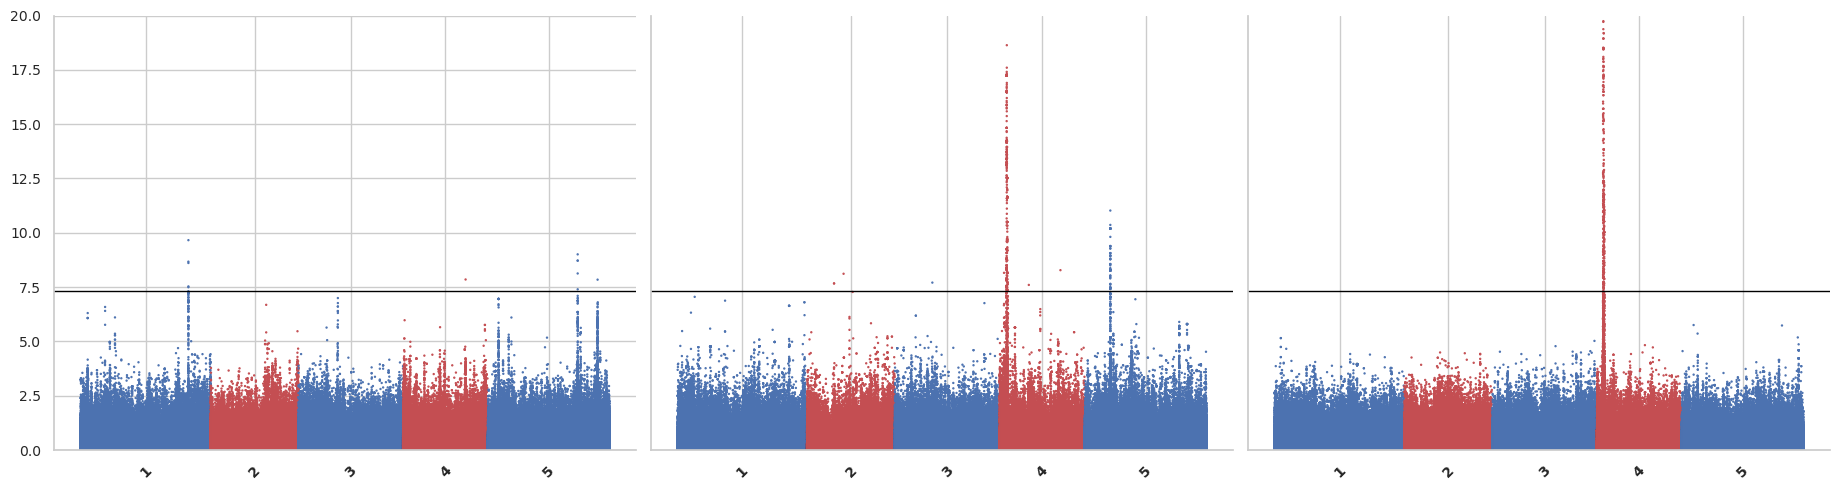

In [23]:
fig, axs = plt.subplots(1,3 , figsize=(18.5, 5))
sns.reset_orig()
plot_gwas('study_12_FT10', axs[0], y_ticks=True, skew_info=False,title=False, fontsize=10)
plot_gwas('herbavore_resistance_G2P', axs[1], y_ticks=False,skew_info=False,title=False, fontsize=10)
plot_gwas('study_4_M130T666', axs[2], y_ticks=False,skew_info=False,title=False, fontsize=10)
plt.tight_layout()
#plt.savefig('figures/figure_3a.svg')
plt.savefig('figures/figure_3a.png', dpi=600)
plt.show()

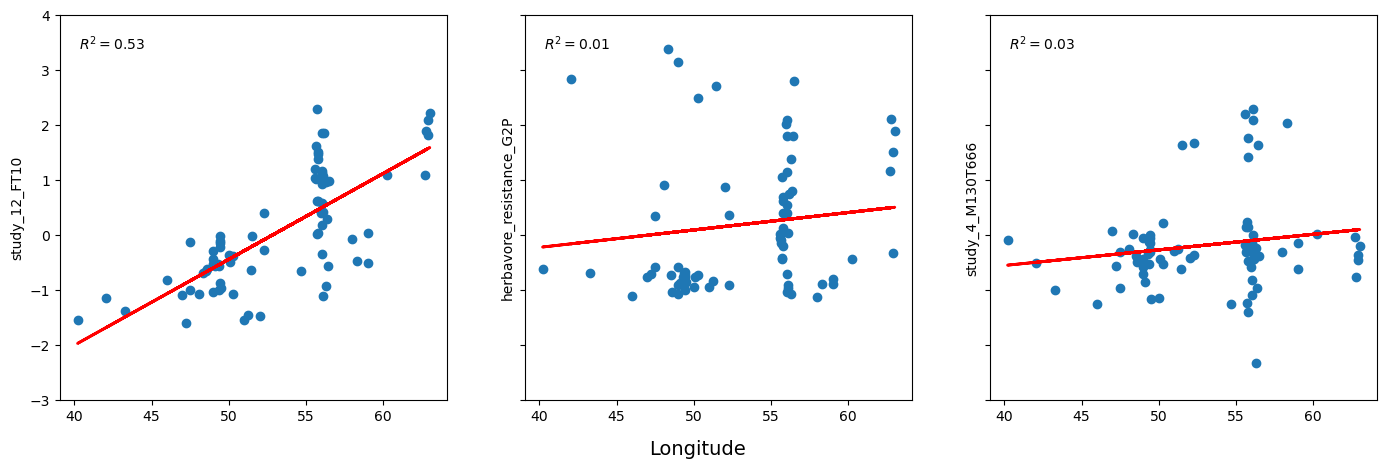

In [24]:
traits = ['study_12_FT10' ,  'herbavore_resistance_G2P', 'study_4_M130T666']
accessions_all = [araData.get_k2029_accessions_with_phenotype(trait).astype(int) for trait in traits]
sns.reset_orig()
inter = accessions_all[0]
for acc in accessions_all[1:]:
    inter = np.intersect1d(inter, acc)

indexes = [np.isin(acc, inter) for acc in accessions_all]
accessions = [araData.get_k2029_accessions_with_phenotype(trait).astype(int)[indexes[i]] for i, trait in enumerate(traits)] 
phenotypes = [araData.get_normalised_phenotype(trait)[indexes[i]] for i, trait in enumerate(traits)] 



lat_long_10001 = pd.read_csv('/Research_Data_new/ReasearchProject/data/10001_genomes_lat_long.csv')
lat_long = lat_long_10001[np.isin(np.array(lat_long_10001['Accession ID']), accessions)][['Lat', 'Long']]

fig, axs = plt.subplots(1,len(traits), figsize= (17/3*len(traits),5), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    x, y = np.array(lat_long['Lat']), phenotypes[i]

    nan_index = np.array([not np.isnan(e) and e >20 for e in x])
    x,y = x[nan_index], y[nan_index]

    ax.scatter(x, y)
    ax.set_ylim(-3,4)
    # Linear regression
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    # Plot line of best fit
    ax.plot(x, y_pred, color="red", linewidth=2)
    # Compute and display R^2 score
    r2 = r2_score(y, y_pred)
    ax.text(0.05, 0.95, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_ylabel(traits[i])

    
fig.text(0.5, 0, 'Longitude', ha='center', fontsize=14)

plt.savefig('figures/figure_3c.svg')
plt.show()

100%|██████████| 36/36 [07:58<00:00, 13.30s/it]


<Figure size 640x480 with 0 Axes>

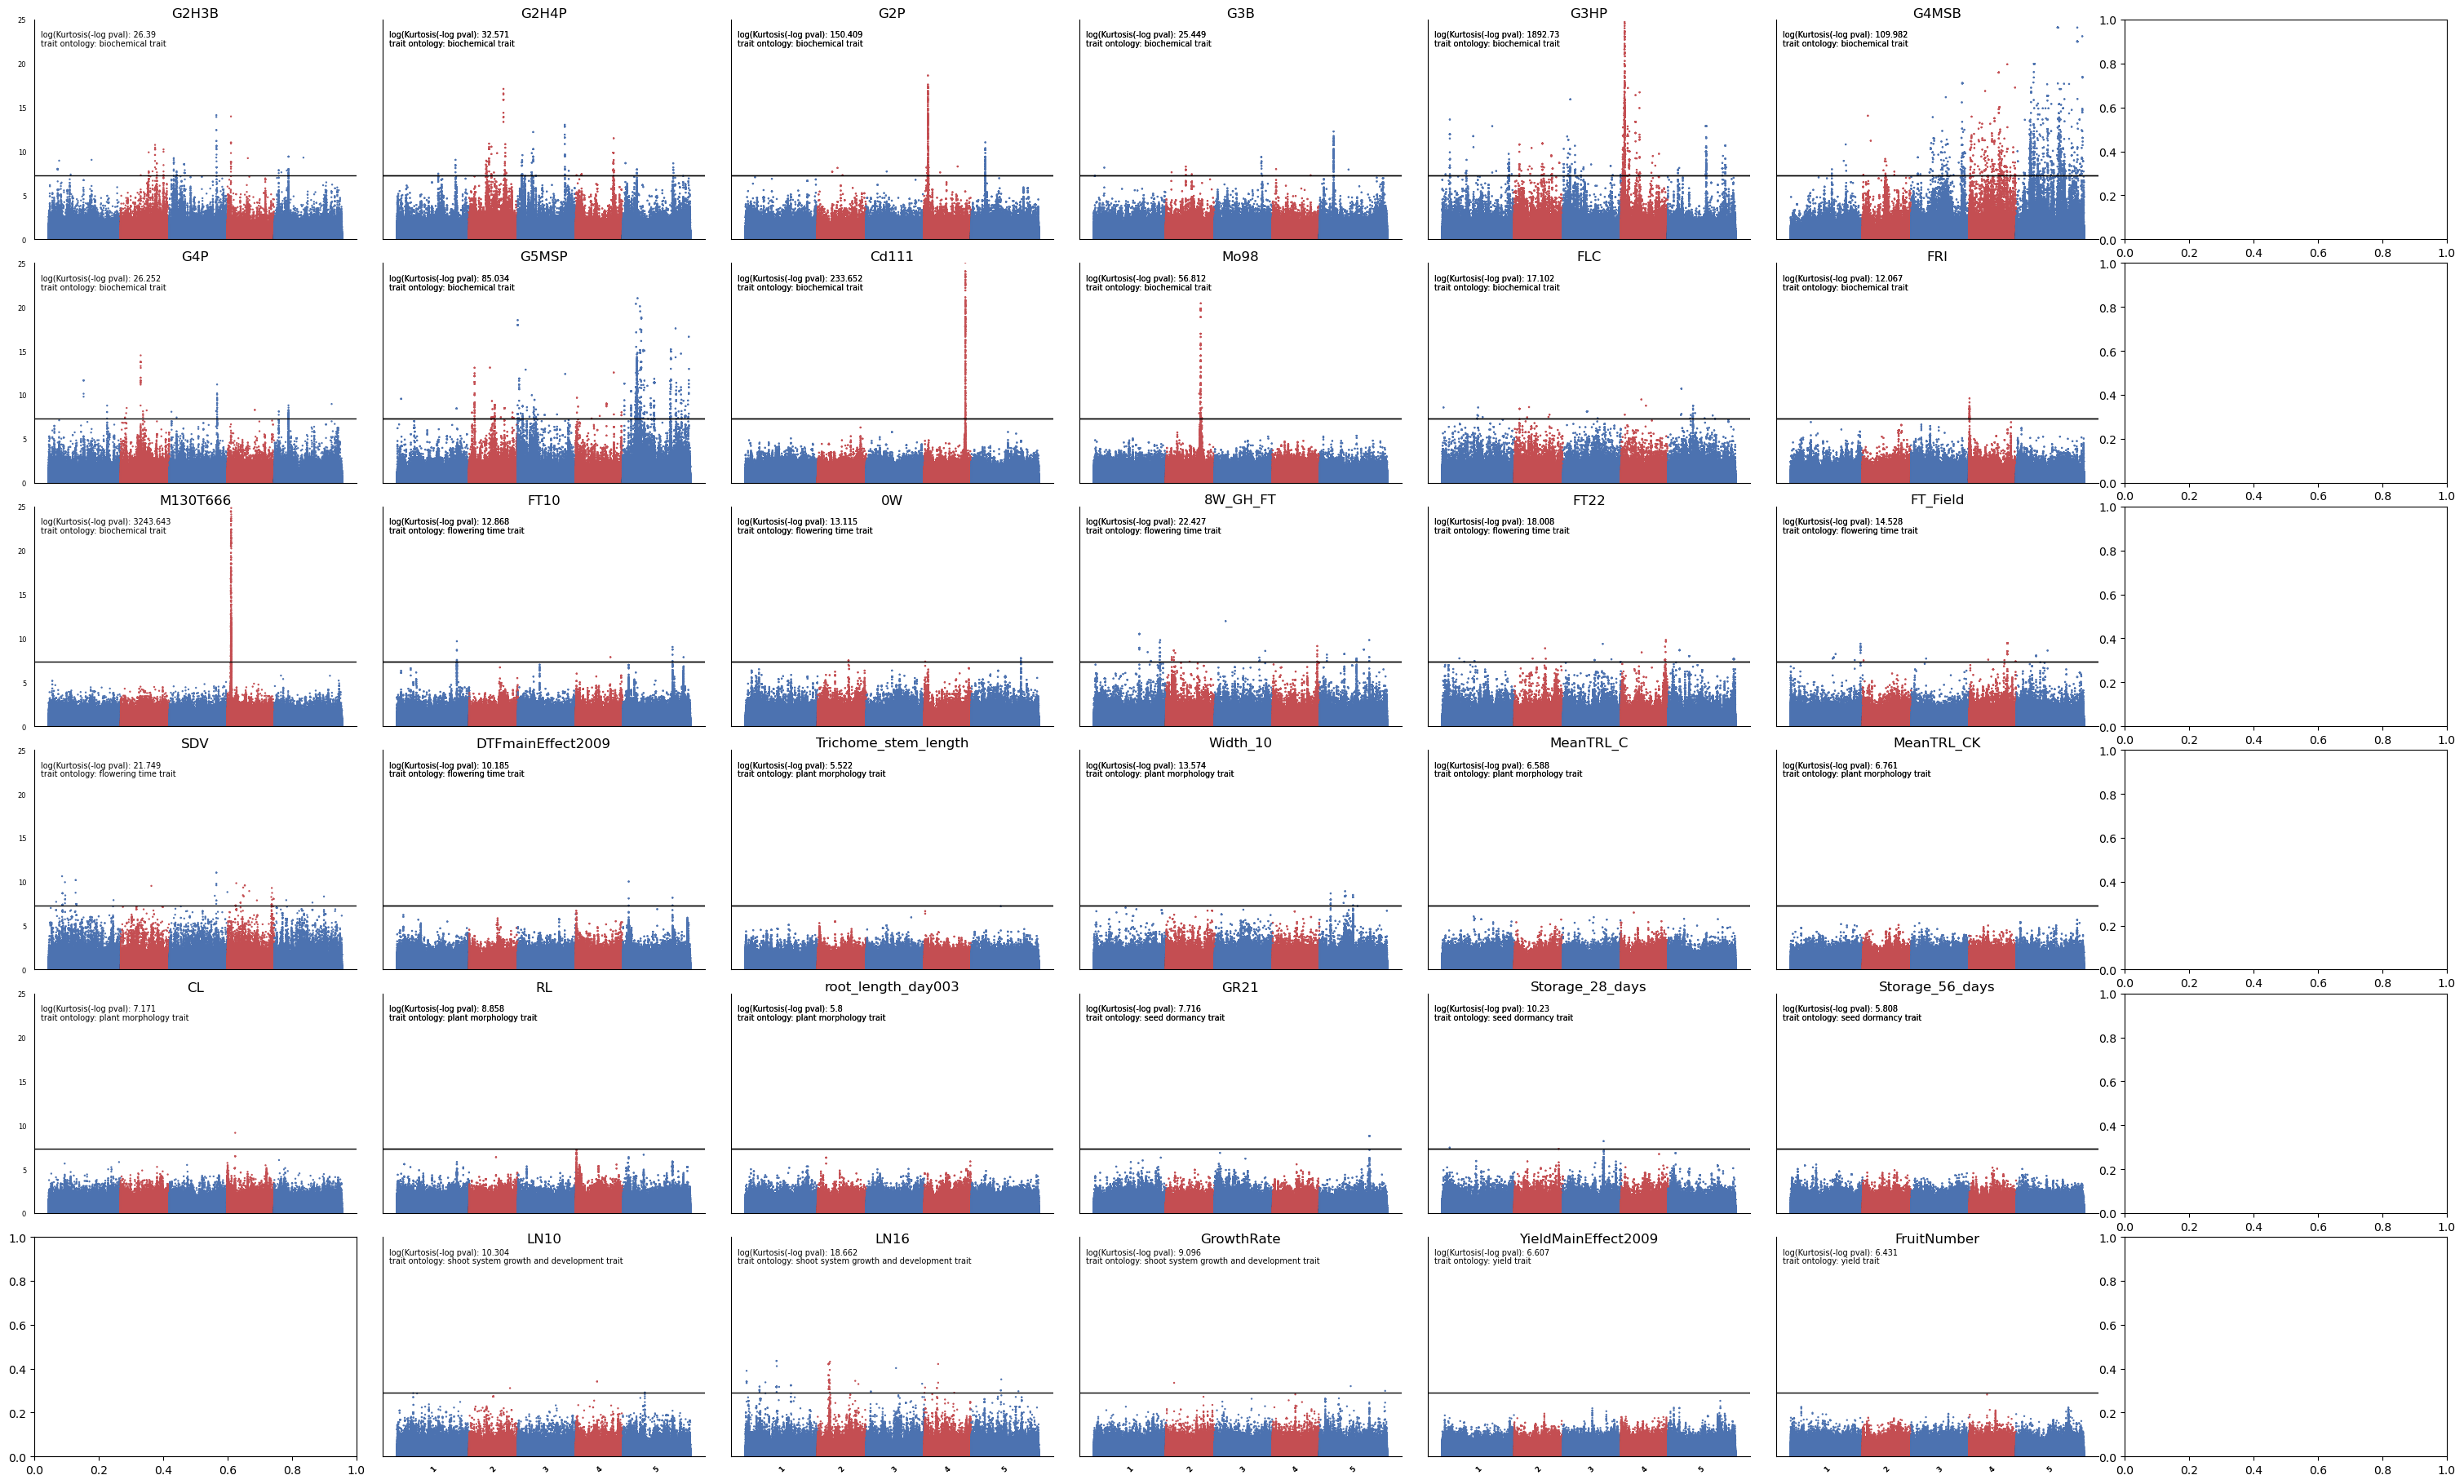

In [25]:
# reload matplotlib
import importlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
sns.reset_orig()

traits = list(info['trait'])
traits = sorted(traits, key = lambda x: (manual_ont[x], trait))

fig, axs = plt.subplots(6,7, figsize=(30,18))

def plot_gwas(trait, ax, y_ticks=True, x_ticks=True):
    colors = ['#4C72B0', '#C44E52']
    path_to_file = f'{trait}/Output/Linear_Mixed_Model/{trait}/{trait}_mod_sub_{trait}_k2029.assoc.txt'
    df = pd.read_csv(f'{path_to_gwas}/{path_to_file}', sep='\t')
    x = np.arange(len(df))
    y =  -np.log10(df['p_wald'])
    # remove where x == 0

    include = np.where(y > 0.01)[0]
    x = x[include]
    y = y[include]
    chrs = np.array(df['chr'])
    point_colors = [colors[0] if chr%2 else colors[1] for chr in chrs[include]]
    ax.scatter(x,y, color=point_colors, s=0.5)
    ax.axhline(-np.log10(5*(10**(-8))), color='black', linestyle='-', linewidth = 1)
    ax.set_ylim(0,25)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    # remove x ticks
    labels = [1,2,3,4,5]
    ax.set_xticks(labels=labels, ticks=[(np.where(chrs==x)[0][0] + np.where(chrs==x)[0][-1])/2 for x in labels], rotation=45, fontweight="bold"
                  )

    #  set front size 
    for label in ax.get_xticklabels():
        label.set_fontsize(6)
    for label in ax.get_yticklabels():
        label.set_fontsize(6)

    ax.text(0.02, 0.95, f"log(Kurtosis(-log pval): {round(skew_dict[trait], 3)}", transform=ax.transAxes, fontsize=7, verticalalignment='top')
    ax.text(0.02, 0.91, f"trait ontology: {(manual_ont[trait][:manual_ont[trait].index(' (')])}", transform=ax.transAxes, fontsize=7, verticalalignment='top')

    for pos in ['right', 'top' ]: 
        ax.spines[pos].set_visible(False)

    if not y_ticks:
        ax.set_yticks([])
    if not x_ticks:
        ax.set_xticks([])

    ax.set_title(re.sub(r'^study_\d+_|^herbavore_resistance_', '', trait), pad=-5)


import itertools
from tqdm import tqdm
for j,i in tqdm(list(itertools.product(range(7), range(6)))[:len(traits)]):
    trait = traits[j + i*6]
    if j != 0:
        plot_gwas(trait, axs[i][j], y_ticks=False)
    if i != 5:
        plot_gwas(trait, axs[i][j], x_ticks=False)
    
plt.tight_layout(pad=0)
plt.show()
fig.savefig('figures/all_gwas.png', dpi=600)